In [382]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, uniform

In [ ]:
def capacity_constrained_ot(x, y, m, n, gamma0, hbar, lmb):
    """
    Constrained Optimal Transport using Dykstra Algorithm
    Reference: Benamou, Carlier, Cuturi, Nenna, Peyré
    "Iterative Bregman Projections for Regularized Transportation Problems"

    Parameters
    ----------
    x, y : 1D numpy arrays
        Grids associated with first and second marginal
    m, n : 1D numpy arrays
        Marginals (mu, nu)
    gamma0 : 2D numpy array
        Initial gamma_ij = exp(-c_ij / lambda)
    hbar : 2D numpy array
        Capacity constraint matrix
    lmb : float
        Entropic regularization parameter

    Returns
    -------
    gamma : 2D numpy array
        Optimal transport plan
    """

    N = len(x)
    wx = x[1] - x[0]
    wy = y[1] - y[0]

    err = 1.0

    # Matrices for Dykstra
    q1 = np.ones((N, N))
    q2 = np.ones((N, N))
    q3 = np.ones((N, N))

    gamma1 = gamma0.copy()
    gamma2 = gamma0.copy()
    gamma3 = gamma0.copy()
    gamma = gamma0.copy()
    gammaN = gamma0.copy()

    oo = np.ones((1, N))
    count = 1

    C = 3

    while err > 1e-4:
        if count % C == 1:
            tmp1 = gamma * q1
            gammaN = np.minimum(tmp1, hbar) # C1 is the non-affine constraint \gamma \leq \bar{\gamma}
            # q1 = tmp1 / gammaN
            with np.errstate(divide='ignore', invalid='ignore'):
                q1 = np.divide(tmp1, gammaN)

            gamma1 = gammaN

        elif count % C == 2:
            tmp1 = gamma * q2
            denom = np.sum(tmp1, axis=1, keepdims=True)

            # gammaN = tmp1 * (m[None, :] / denom) # C2 is the row normalisation constraint
            with np.errstate(divide='ignore', invalid='ignore'):
                factor = np.divide(m[:, None], denom)
            gammaN = tmp1 * factor # C2 is the column normalisation constraint

            q2 = tmp1 / gammaN
            gamma2 = gammaN

        else:
            tmp1 = gamma * q3
            denom = np.sum(tmp1, axis=0, keepdims=True)

            # gammaN = tmp1 * (n[None, :] / denom) # C3 is the col normalisation constraint
            with np.errstate(divide='ignore', invalid='ignore'):
                factor = np.divide(n[None, :], denom)
            gammaN = tmp1 * factor

            q3 = tmp1 / gammaN
            gamma3 = gammaN

        if count >= 3:
            err = (
                np.sum(np.abs(gammaN - gamma1))
                + np.sum(np.abs(gammaN - gamma2))
                + np.sum(np.abs(gammaN - gamma3))
            )

        print(f"Error at step ({count}): {err}")
        gamma = gammaN
        count += 1

    # Plot gamma
    plt.pcolormesh(x, y, gamma, shading="auto", cmap="gray_r")
    plt.colorbar()
    plt.title(r'Capacity-Constrained Map ($\bar{\gamma} = $'+f'{np.max(hbar)})')
    plt.show()

    return gamma


In [384]:
N = 101
xa, xb = 0, 2
ya, yb = 0, 2
x = np.linspace(xa, xb, N)
y = np.linspace(ya, yb, N)

def mu(x):
    return norm.pdf(x, loc=1., scale=0.5)

def nu(y):
    return uniform.pdf(y, loc=ya, scale=yb)


oo = np.ones((1, N))
lmb = 1e-3

# exponential kernel
def h(x, y):
    return np.exp(-(0.5 * (np.abs(x - y) ** 2)) / lmb) + 1e-200 # force all elements to be non-zero

gamma0 = h(x[:, None], y[None, :])

# capacity constraint
hbar = 0.001 * np.ones((N, N))

# normalize marginals if not equal total mass
m = mu(x)
m /= sum(m)
n = nu(y)
n /= sum(n)

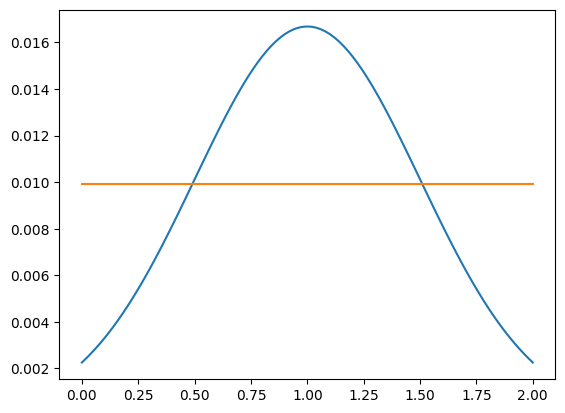

In [385]:
fig, ax = plt.subplots()

ax.plot(x, m, label='mu(x)')
ax.plot(y, n, label='nu(y)')

Error at step (1): 1.0
Error at step (2): 1.0
Error at step (3): 0.6910240390835469
Error at step (4): 0.6620575851748427
Error at step (5): 0.8515643035057657
Error at step (6): 0.6563653477552271
Error at step (7): 0.6421613253312245
Error at step (8): 0.8448462652909776
Error at step (9): 0.6361337785397658
Error at step (10): 0.6326925891380617
Error at step (11): 0.84249323620193
Error at step (12): 0.6236340508221565
Error at step (13): 0.6202628484919166
Error at step (14): 0.8375825412806719
Error at step (15): 0.6112551989562796
Error at step (16): 0.595090204886559
Error at step (17): 0.824744075313333
Error at step (18): 0.5933162211884907
Error at step (19): 0.5761887640062968
Error at step (20): 0.8110896124153528
Error at step (21): 0.5743824256921675
Error at step (22): 0.5611603705164129
Error at step (23): 0.8014040010343656
Error at step (24): 0.5591533595833973
Error at step (25): 0.5478752872133651
Error at step (26): 0.7949893008168907
Error at step (27): 0.5459020

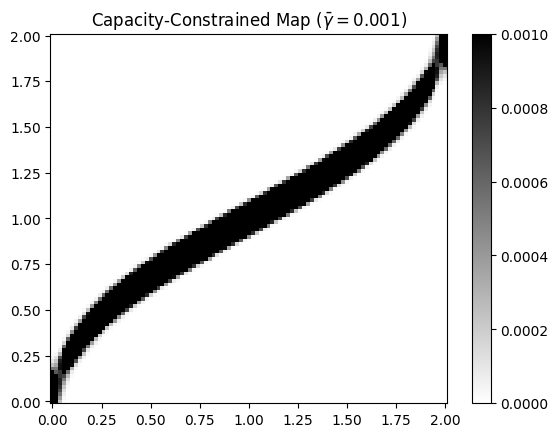

In [386]:
gamma = capacity_constrained_ot(x, y, m, n, gamma0, hbar, lmb)

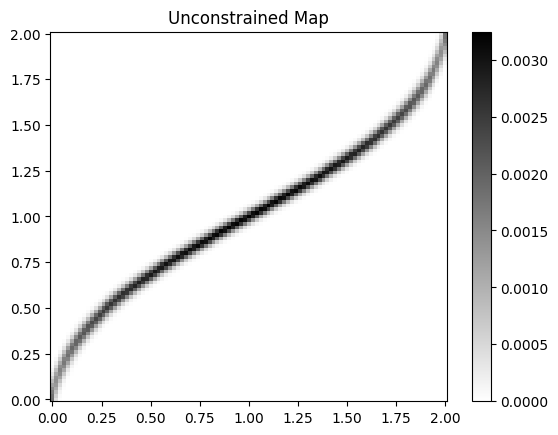

In [387]:
from ott.geometry import pointcloud, geometry
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem

geom = pointcloud.PointCloud(x.reshape(-1, 1).astype(np.float32), y.reshape(-1, 1).astype(np.float32), epsilon=lmb*2) #SqEuclidean is default cost
problem = linear_problem.LinearProblem(geom, m, n)
output = sinkhorn.Sinkhorn()(problem)

plt.pcolormesh(x, y, output.matrix, shading="auto", cmap="gray_r")
plt.colorbar()
plt.title('Unconstrained Map')
plt.show()